In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

In [5]:
cd /content/drive/MyDrive/AI-2025-study

/content/drive/MyDrive/AI-2025-study


In [6]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv('data/IMDB-Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.3)
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 15000
    })
})

In [8]:
# input_ids, attention_mask, label -> numbers


In [9]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [10]:
labels2id = {
    'negative': 0,
    'positive': 1
}
id2labels = {
    0: 'negative',
    1: 'positive'
}

In [11]:
dataset = dataset.map(lambda x: {'label': labels2id[x['sentiment']]})

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [12]:
dataset['train'][0]

{'review': 'I pretty much liked every character on this show from the start except Reba herself. She comes off as an holier than thou type and quite frankly a big Bully. And that stinks because she is in every scene and every episode. In the later seasons Van becomes unlikeable too,like a spoof of his former self. and Kyra walks around sneering and being miserable.The first 3 to 4 seasons are pretty good if you overlook Reba. Towards the end its pretty bleak.. In basically every episode Barbara jean Is walking around being dumb,Reba is being mean to her,but poor Ole Barbara jean desperately wants Reba to like her which results in Barabara jean telling Reba how awesome she is in every episode. I think it is pretty clear to see Reba has self esteem issues and wants to be seen as this all forgiving saint. Its really a shame too because other than her the show had such potential.',
 'sentiment': 'negative',
 'label': 0}

In [13]:
from transformers import AutoTokenizer
import torch



In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# custom_cache_dir = "D:/app/llm-model"
model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

In [15]:
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt, cache_dir=custom_cache_dir)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [16]:
tokenizer(dataset['train'][0]['review'])

def tokenize(batch):
    temp = tokenizer(batch['review'], padding=True, truncation=True, max_length=300)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [17]:
dataset['train'][0].keys()

dict_keys(['review', 'sentiment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

### Model evaluation
https://huggingface.co/docs/transformers/en/tasks/sequence_classification#evaluate

In [18]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


In [19]:
import evaluate
import numpy as np

In [20]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

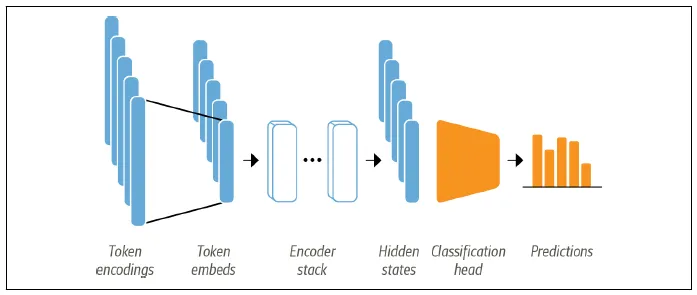

In [21]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(labels2id),
    label2id=labels2id,
    id2label=id2labels,
    # cache_dir=custom_cache_dir
)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer

)

model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

In [24]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bdanhcse-work (bdanhcse-work-ho-chi-minh-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.349000,0.321041
2,0.289100,0.308124
3,0.251400,0.305827


TrainOutput(global_step=3282, training_loss=0.3153106833579408, metrics={'train_runtime': 1677.4072, 'train_samples_per_second': 62.597, 'train_steps_per_second': 1.957, 'total_flos': 882184338000000.0, 'train_loss': 0.3153106833579408, 'epoch': 3.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.30582714080810547,
 'eval_runtime': 26.2983,
 'eval_samples_per_second': 570.378,
 'eval_steps_per_second': 17.834,
 'epoch': 3.0}

## Model save and load for inference

In [27]:
trainer.save_model('tinybert-sentiment-analysis')

In [28]:
data = [
    'this movie was horrible, the plot was really boring. acting was okay',
    'the movie is really sucked. there is not plot and acting was bad',
    'what a beautiful movie. great plot. acting was good. will see it again'
]

In [29]:
from transformers import pipeline

In [30]:
classifier = pipeline('text-classification', model='tinybert-sentiment-analysis', device='cuda')

Device set to use cuda


In [31]:
classifier(data)

[{'label': 'negative', 'score': 0.990210771560669},
 {'label': 'negative', 'score': 0.9897408485412598},
 {'label': 'positive', 'score': 0.9903762936592102}]

### Push model to S3


In [1]:
import boto3

In [13]:
import logging
import boto3
from botocore.exceptions import ClientError
import os
s3 = boto3.client('s3')

def create_bucket(bucket_name, region=None):
    """Create an S3 bucket in a specified region

    If a region is not specified, the bucket is created in the S3 default
    region (us-east-1).

    :param bucket_name: Bucket to create
    :param region: String region to create bucket in, e.g., 'us-west-2'
    :return: True if bucket created, else False
    """

    # Create bucket
    if(bucket_exist(bucket_name)):
        try:
            if region is None:
                s3_client = boto3.client('s3')
                s3_client.create_bucket(Bucket=bucket_name)
            else:
                s3_client = boto3.client('s3', region_name=region)
                location = {'LocationConstraint': region}
                s3_client.create_bucket(Bucket=bucket_name,
                                        CreateBucketConfiguration=location)
        except ClientError as e:
            logging.error(e)
            return False
        return True
    else:
        return False

def bucket_exist(bucket_name):
    response = s3.list_buckets()
    buckets = [bucket['Name'] for bucket in response['Buckets']]
    if bucket_name not in buckets:
        return True
    else:
        print("Bucket is already created!!")
        return False


In [11]:
bucket_name = 'mlops-anansupercute'
region = 'ap-southeast-1'
create_bucket(bucket_name=bucket_name, region=region)

Bucket is already created!!


False

In [12]:
# Retrieve the list of existing buckets
s3 = boto3.client('s3')
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  mlops-anansupercute


In [ ]:
def upload_directory(directory_path, s3_prefix): 
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/") 
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/") 
            s3.upload_file(file_path, bucket_name, s3_key)
            
upload_directory('tinybert-sentiment-analysis', 'ml-models/tinybert-sentiment-analysis')
